# SVM with Docking Scores

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append('..')

In [2]:
from modules.plotting_metrics import PlotMetric
import matplotlib.pyplot as plt
import seaborn as sns

#### Run the helper funtions from the [Helper notebook](./Helpers.ipynb)

In [3]:
%run ./helper_functions_S6.ipynb

## Ensemble Docking con ligandos CSAR
- #### 111 ligandos
    - 27 Activos
- #### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [4]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_CSAR, y_dksc_CSAR = \
open_results(path = '../data/docking_scores/vs_docking_crys_ensemble_VINARDO.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dksc_CSAR", X_dksc_CSAR.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_CSAR, y_dkef_CSAR = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_CSAR_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dkef_CSAR", X_dkef_CSAR.shape)

Dims X_dksc_CSAR (111, 402)
Dims X_dkef_CSAR (111, 402)


## Ensemble Docking con ligandos DUD (2006)
- ### 2146 ligandos
    - 72 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [5]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DUD, y_dksc_DUD = \
open_results(path = '../data/docking_scores/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dksc_DUD", X_dksc_DUD.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_DUD, y_dkef_DUD = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_DUD2006_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dkef_DUD", X_dkef_DUD.shape)

Dims X_dksc_DUD (2146, 402)
Dims X_dkef_DUD (2146, 402)


## Ensemble Docking con ligandos DEKOIS 2.0
- ### 1240 ligandos
    - 40 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [6]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DEKOIS, y_dksc_DEKOIS = open_results(
    path = '../data/docking_scores/vs_dk_CRYS_402_DEKOIS_VINARDO_docking_score.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dksc_DEKOIS", X_dksc_DEKOIS.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_DEKOIS, y_dkef_DEKOIS = \
open_results(
    path = '../data/docking_scores/vs_dk_CRYS_402_DEKOIS2_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dkef_DEKOIS", X_dkef_DEKOIS.shape)

Dims X_dksc_DEKOIS (1240, 402)
Dims X_dkef_DEKOIS (1240, 402)


In [7]:
# Finally we create adictionary that we will use to combine different approaches
scores_dic = {'CSAR': {'Dk_sc':   {'X': X_dksc_CSAR, 'y': y_dksc_CSAR}, 
                       'Dk_lef':  {'X': X_dkef_CSAR, 'y': y_dkef_CSAR} },
              'DUD':  {'Dk_sc':   {'X': X_dksc_DUD,  'y': y_dksc_DUD}, 
                       'Dk_lef':  {'X': X_dkef_DUD,  'y': y_dkef_DUD} },
              'DEKOIS': {'Dk_sc': {'X': X_dksc_DEKOIS,  'y': y_dksc_DEKOIS}, 
                       'Dk_lef':  {'X': X_dkef_DEKOIS,  'y': y_dkef_DEKOIS} },
             }

In [8]:
# Create the ranked versions
import copy
scores_copy = copy.deepcopy(scores_dic)

for dataset in scores_copy.keys():
    for score in scores_copy[dataset]:
        rk_name = 'Rk' + score[2:]
        scores = scores_copy[dataset][score]
        scores_dic[dataset][rk_name] = {'X': scores['X'].rank(), 'y': scores['y']}
        

## Pipeline

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer, f1_score

In [10]:
def train_model(X_train, y_train, estimator, estimator_params = None,
               scoring = 'roc_auc', k_folds = 5, standarize = True, 
               split_train = False, test_size = 0.2, random_state = 1, **kwargs):
    '''
     1) Pipeline is created, and will perform StandarScaler. More steps can be added later.
     # pipe args is a list of tuples initialized with one element; the estimator.
     # If standarize = true it adds StandardScaler at the bigining of the pipe.
    '''
    pipe_args = [("estimator", estimator(**kwargs))]
    if standarize:
        pipe_args.insert(0, ("scaler", StandardScaler()))
    pipe = Pipeline(pipe_args)
    '''
    2) The specific hyperparameters of the selected stimator are given, 
    we will parse them to the gridSearch instance.
    '''
    if estimator_params != None:
        params = {}
        for key, value in estimator_params.items():
            params['estimator__' + key] = value
    '''
    3) Grid search cross validation for turning the optimal parameters, 
    it takes the pipeline object. GridSearch performs k-fold cross validation, 
    and uses the given scoring method to validate each set.
    '''
    grid = GridSearchCV(estimator = pipe, param_grid = params, 
                        cv = k_folds, scoring = scoring,
                        n_jobs = 6, refit=True)
    '''SVC training through GridSearch object'''
    if split_train:
        X_train, X_test, y_train, y_test = \
        train_test_split(X_train, y_train, test_size = test_size,
                         stratify = y_train, random_state = random_state)
    grid.fit(X_train, y_train)
    '''Return the trained estimator'''
    return(grid)

def eval_model(model, X_test, y_test):
    '''
    1) Predictions and evaluation on the Test set
    - Scaling and prediction of X_train using the best model found by grid
    '''
    y_prob  = model.predict_proba(X_test)[:,1] # Predicted prob values for X_test
    #y_score = model.decision_function(X_test) 
    y_pred  = model.predict(X_test) # predicted values
    '''Returns the y_score values and the lnear_SVC object'''
    return(y_prob)

### model wrapper

###  Linear Support Vector Classifier
<div style='background-color: #F9E5AB; min-height: 5px'></div>

The following **linear SVM** is trained using **CSAR** (*Dk_sc* and *Dk_lef*, respectively) and testing with **DUD** and **DEKOIS**.  
All conformations (402 features) are used.

<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>Linear SVC</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>CSAR</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD and DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 402 conformations</i>.
    </li>
</ol>

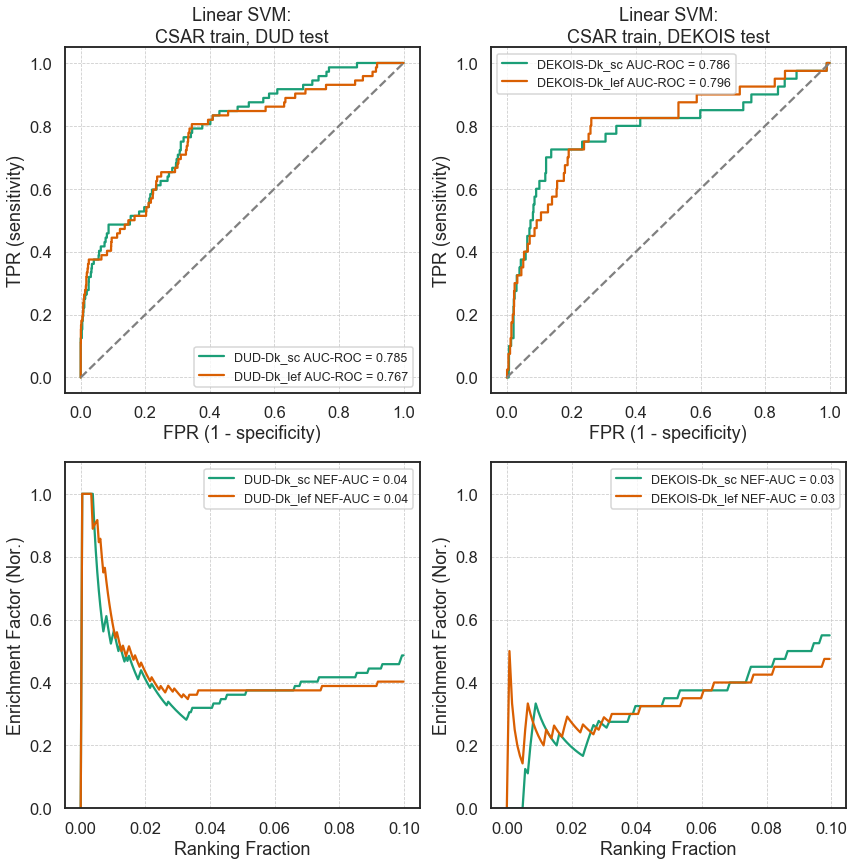

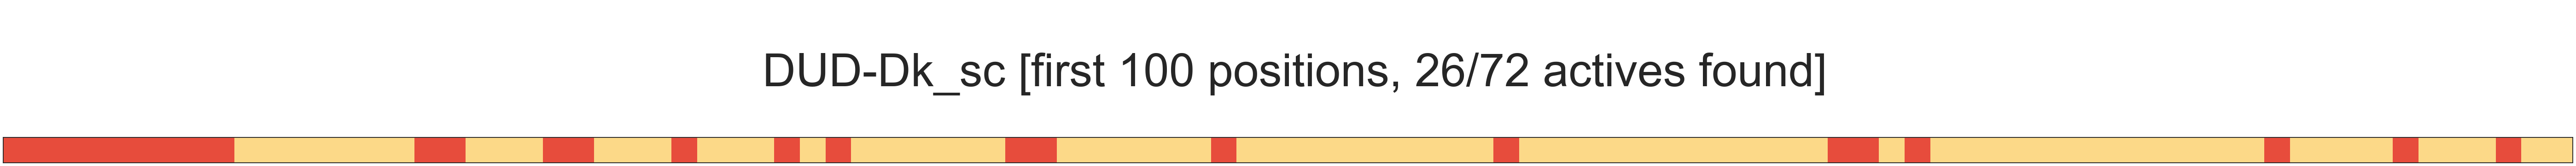

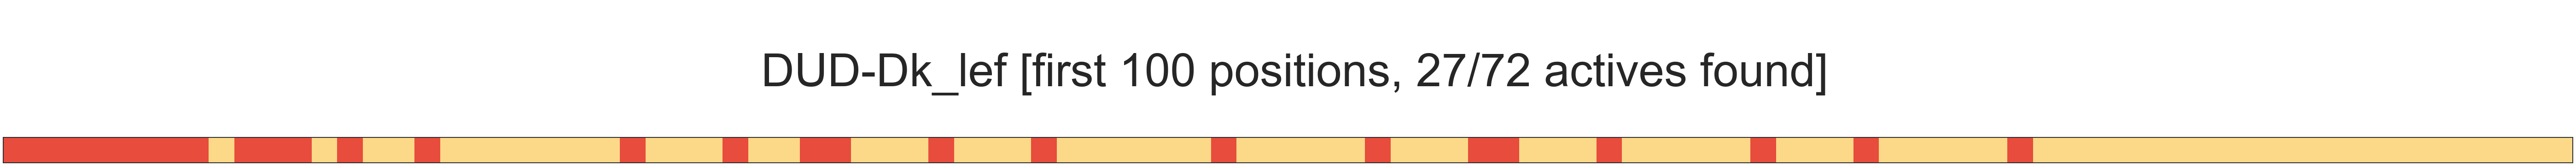

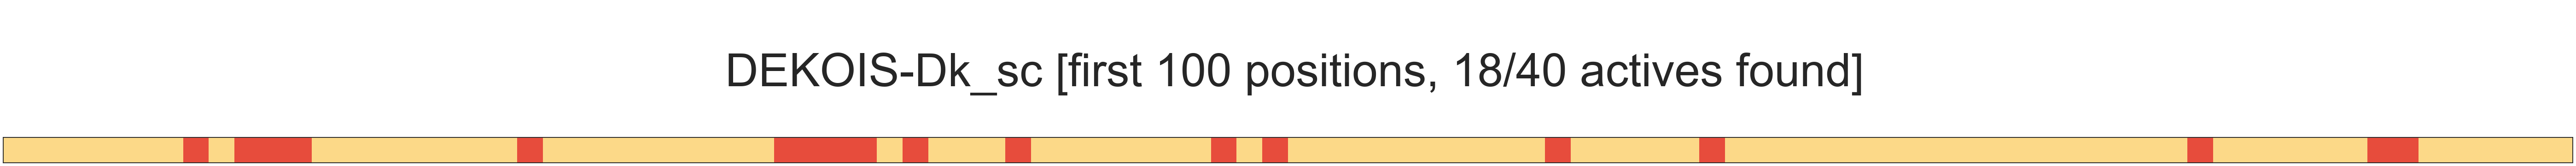

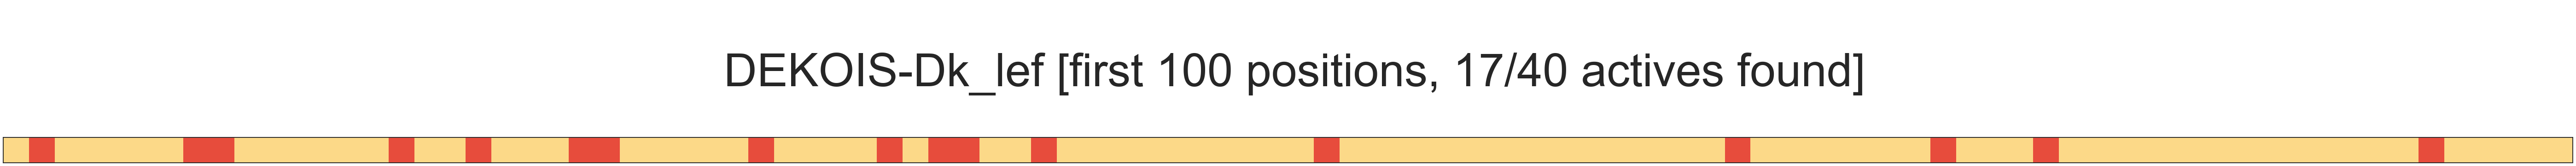

In [12]:
# Params to eval through grid search
svc_params = {'C': np.geomspace(0.1, 100, 4)}
# IMPORTANT: The following code trains as many models as the the number of elements in list_of_scores
list_of_scores = ['Dk_sc', 'Dk_lef']
# In this case, one model will be train for CSAR-Dk_sc and a different model for CSAR-Dk_leff

# The dataset that will be used for trining the model
train_key = 'CSAR'
# The name of the datasets which will be used for  testing
test_keys = ['DUD', 'DEKOIS']

# TRAINING PHASE: The algorithm only 'sees' the train_key set
svm = SVC # Intance the estimator to be used
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= SVC, estimator_params = svc_params,
                        # kwargs exclusive for SVC
                        kernel = 'linear', probability = True)

# TESTING PHASE: Evaluation of the model with the given sets (test_keys)
svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization

plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = True)


***
###  Radial Basis Function SVC
<div style='background-color: #F9E5AB; min-height: 5px'></div>

<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>RBF SVC</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>CSAR</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD and DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 402 conformations</i>.
    </li>
</ol>

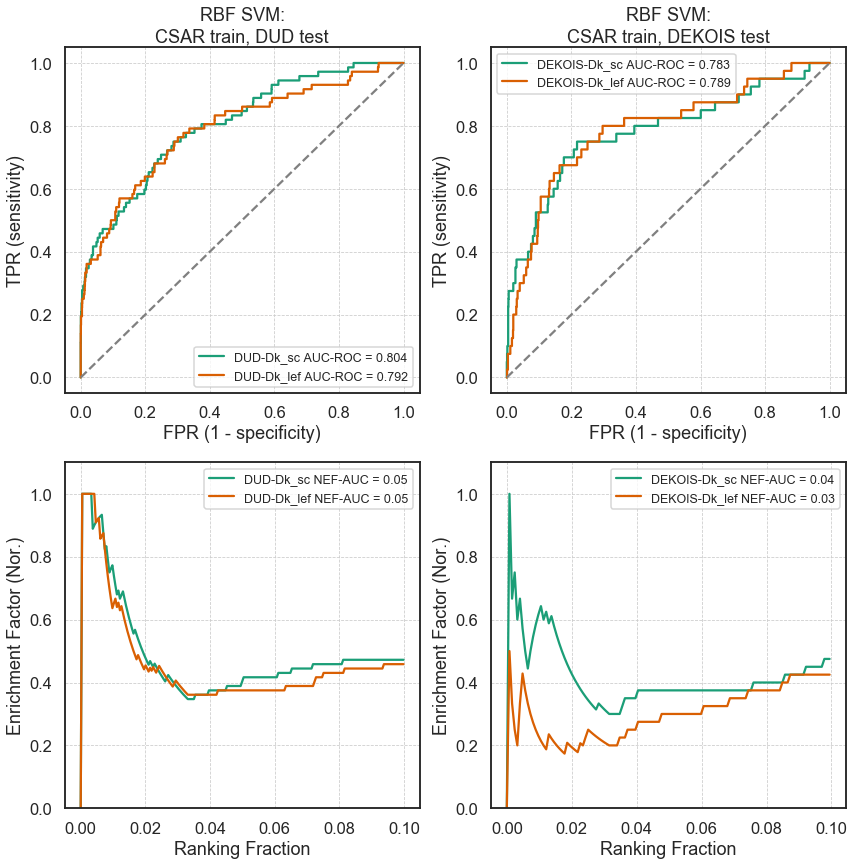

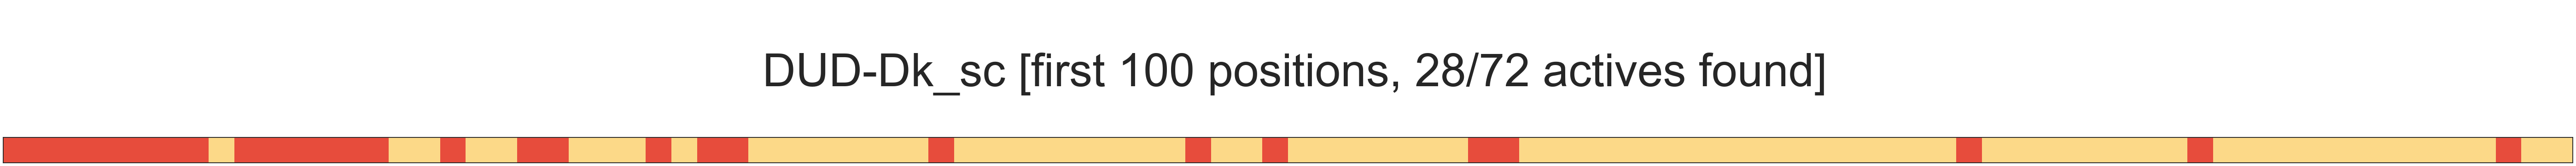

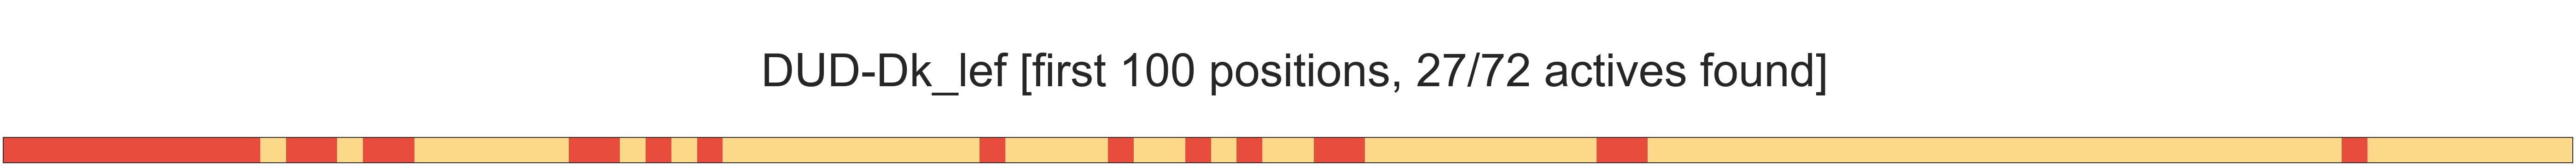

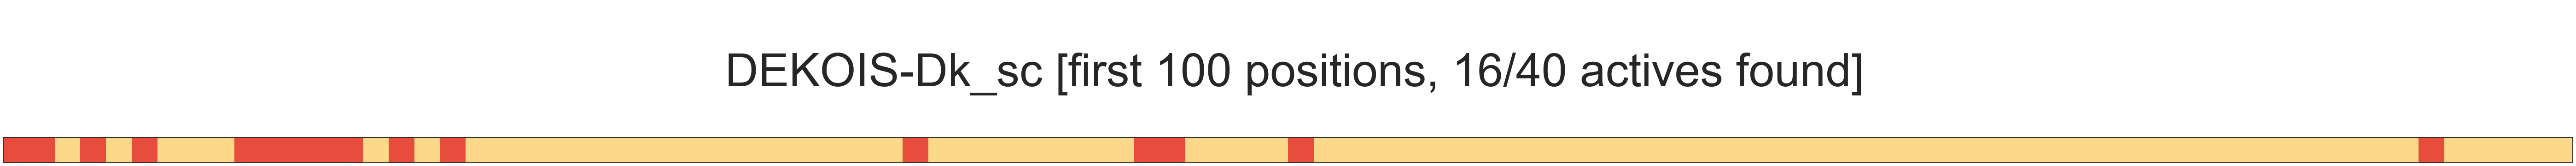

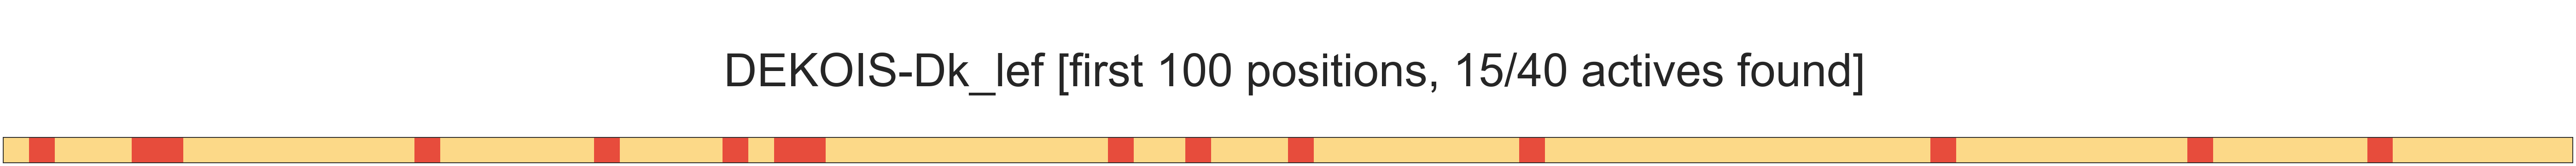

In [13]:
svc_params = {'gamma': [0.001, 0.01, 0.1, 1, 10], 'C': np.geomspace(0.1, 100, 4)}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
# Training phase
svm = SVC
svm_rbf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= SVC, estimator_params = svc_params,
                        kernel = 'rbf', probability = True)
# Evaluation
svm_rbf_pred = eval_wrapper(trained_model = svm_rbf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'RBF SVM', predictions = svm_rbf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = True)

***
### Logistic Regression
<div style='background-color: #F9E5AB; min-height: 5px'></div>
<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>Logistic Regression</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>CSAR</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD and DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 402 conformations</i>.
    </li>
</ol>

In [14]:
from sklearn.linear_model import LogisticRegression

/home/linuxlite/anaconda3/envs/mds/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Model for Dk_sc:
	Best parameters: {'estimator__C': 0.001, 'estimator__penalty': 'none', 'estimator__solver': 'lbfgs'}
	Train set accuracy: 0.984
Model for Dk_lef:
	Best parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
	Train set accuracy: 0.992


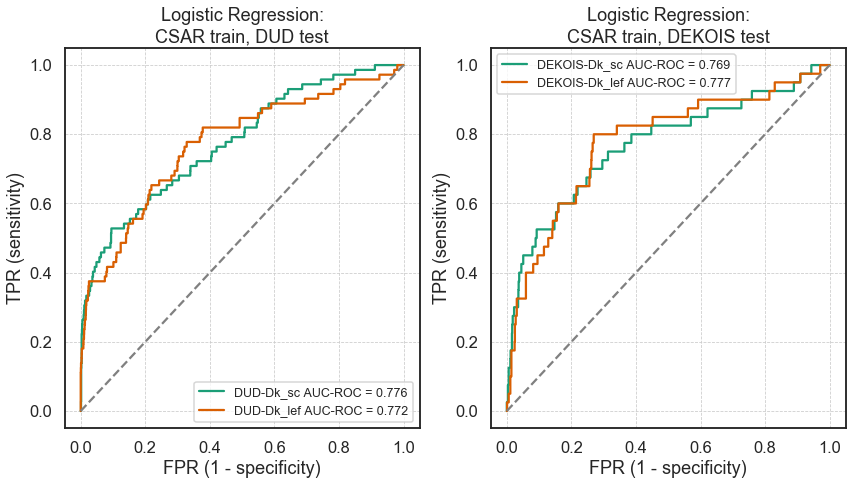

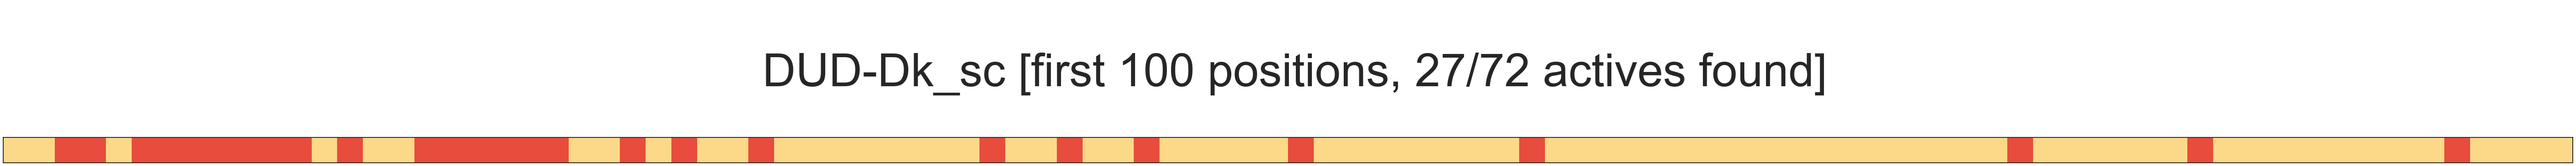

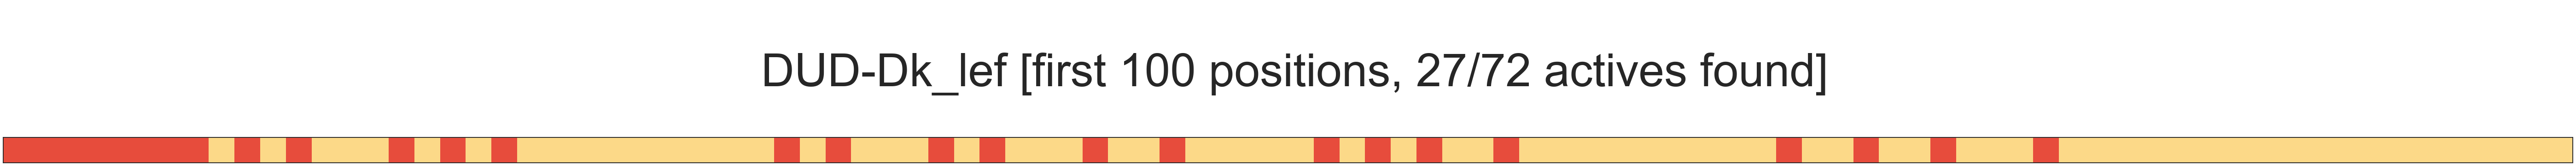

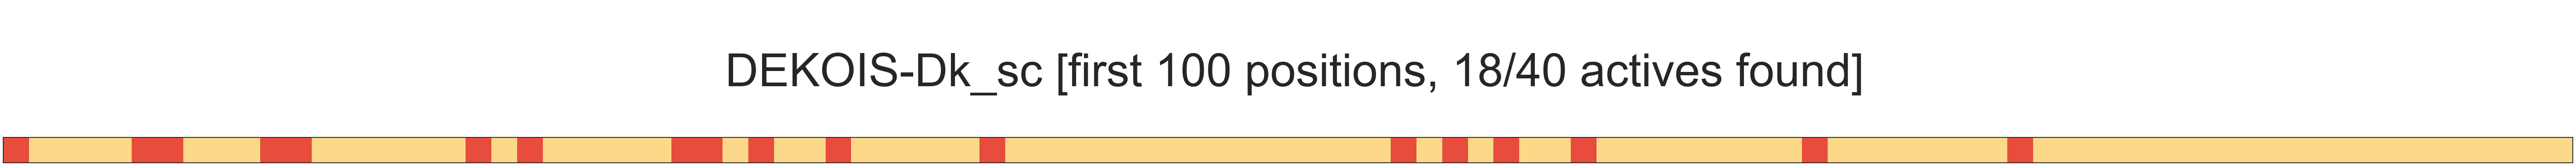

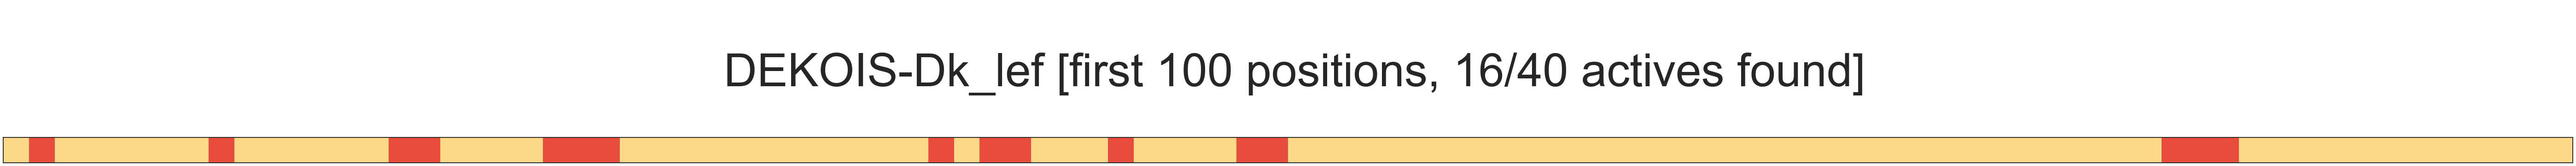

In [15]:
lg_params = {'C': [0.001, 0.01, 0.1], 
             'penalty': ['l1', 'l2', 'none'], 'solver': ['lbfgs', 'liblinear']}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']

# Training phase
LG = LogisticRegression
lg_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= LG, estimator_params = lg_params)
# Parameters used
for name, model in lg_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')
# Evaluation
lg_clf_pred = eval_wrapper(trained_model = lg_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Logistic Regression', predictions = lg_clf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)

***
### Decision Tree Clasiffier
<div style='background-color: #F9E5AB; min-height: 5px'></div>
<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>Decision Tree</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>CSAR</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD and DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 402 conformations</i>.
    </li>
</ol>

In [16]:
from sklearn.tree import DecisionTreeClassifier

Model for Dk_sc:
	Best parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 2}
	Train set accuracy: 0.821
Model for Dk_lef:
	Best parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 2}
	Train set accuracy: 0.766


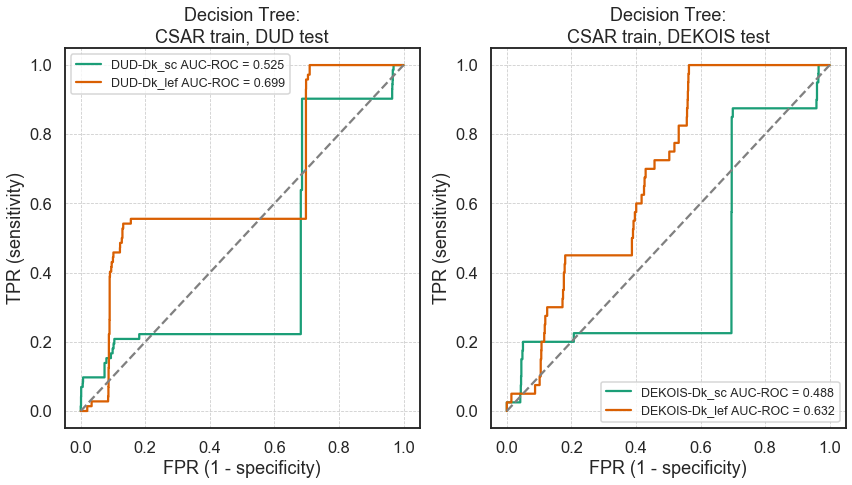

In [17]:
tree_params = {'criterion': ['gini'],
              'max_depth': [2, 3, 4, 5, 10]}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']

# Training phase
TREE = DecisionTreeClassifier
tree_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= TREE, estimator_params = tree_params,
                        standarize = False)
# Parameters used
for name, model in tree_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# Evaluation
tree_clf_pred = eval_wrapper(trained_model = tree_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Decision Tree', predictions = tree_clf_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)

#### Decision Tree Visualization

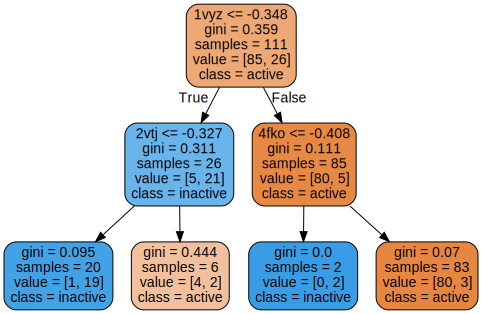

In [18]:
# Visualization
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
sns.set( context = 'paper', style = 'white', font_scale = 0.5)

# Graph tree
feature_names = scores_dic['CSAR']['Dk_lef']['X'].columns
estimator = tree_clf['Dk_lef'].best_estimator_['estimator']
graph = Source(export_graphviz(estimator, filled = True, rounded = True,
                        out_file=None, feature_names = feature_names, 
                        class_names = ['active', 'inactive']))

display(SVG(graph.pipe(format='svg')))

In [19]:
tree_LEFF = tree_clf['Dk_lef'].best_estimator_['estimator']
importances_ = tree_LEFF.feature_importances_[tree_LEFF.feature_importances_ > 0]
features_tree = feature_names[tree_LEFF.feature_importances_ > 0]

print('Feature importances TREE (Dk_Lef):')
for feature_, importance_ in zip(features_tree, importances_):
    print(F'\t{feature_}: {round(importance_, 3)}')

Feature importances TREE (Dk_Lef):
	1vyz: 0.758
	2vtj: 0.119
	4fko: 0.123


## Random Forest Clasiffier
<div style='background-color: #F9E5AB; min-height: 5px'></div>
<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>Decision Tree</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>CSAR</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD and DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 402 conformations</i>.
    </li>
</ol>

In [20]:
from sklearn.ensemble import RandomForestClassifier

Model for Dk_sc:
	Best parameters: {'estimator__max_features': 30, 'estimator__n_estimators': 20}
	Train set accuracy: 0.895
Model for Dk_lef:
	Best parameters: {'estimator__max_features': 30, 'estimator__n_estimators': 20}
	Train set accuracy: 0.888


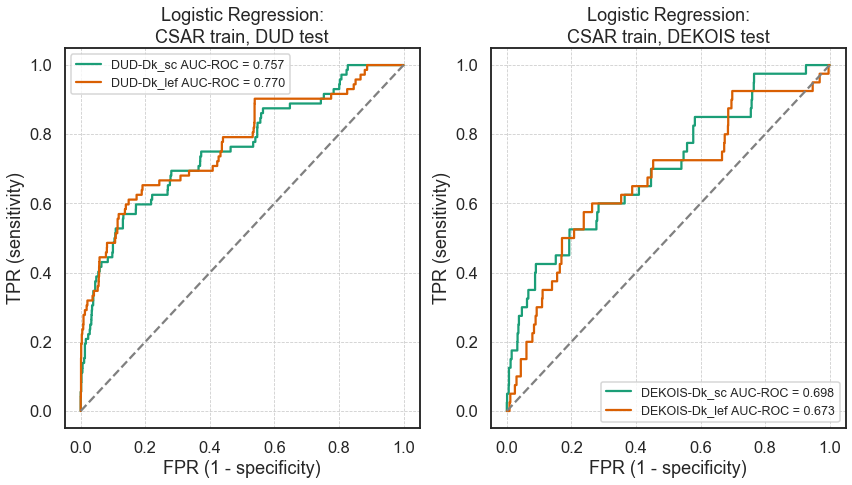

In [21]:
rf_params = {'n_estimators': [20],
             'max_features': [5, 10, 20, 30]}

list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']

# Training phase
RF = RandomForestClassifier
rf_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                       estimator_params = rf_params, standarize = False,
                       estimator= RF, n_jobs = -1)

# Parameters used
for name, model in rf_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# Evaluation
rf_clf_pred = eval_wrapper(trained_model = rf_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Logistic Regression', predictions = rf_clf_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)

### Feature selection with Random Forest

In [22]:
from sklearn.feature_selection import SelectFromModel

In [23]:
# fitted model for Dk L. Eff score
model_rf = rf_clf['Dk_lef'].best_estimator_['estimator']
# We should pass the fitted model
sel_features = SelectFromModel(model_rf, prefit= True)

In [24]:
feature_names[sel_features.get_support()]

Index(['1ckp', '1e1x', '1gz8', '1h08', '1h1q', '1h28', '1ke6', '1ke7', '1p5e',
       '1urc', '1v1k', '1vyz', '1w8c', '2a0c', '2bpm', '2c4g', '2c5y', '2cjm',
       '2fvd', '2iw9', '2j9m', '2r3j', '2r3l', '2r3p', '2r64', '2vtj', '2vto',
       '2vts', '2wma', '2wpa', '2xnb', '3eid', '3eoc', '3fz1', '3lfq', '3my5',
       '3pxq', '3qqk', '3qu0', '3qwj', '3qzh', '3r6x', '3r7v', '3r7y', '3r8v',
       '3rah', '3rk7', '3rkb', '3rni', '3roy', '3rpv', '3wbl', '4bcp', '4bgh',
       '4cfw', '4cfx', '4eol', '4fki', '4fkl', '4fkq', '4fks', '4rj3', '5oo3',
       '6gub', '6guf', '6q3f', '6q4j'],
      dtype='object')

In [25]:
len(feature_names[sel_features.get_support()])

67

# Filtering Features

In [26]:
RF_features = SelectFromModel(model_rf, prefit= True, max_features = 15)
conformaciones = X_dkef_CSAR.columns[RF_features.get_support()]
conformaciones

Index(['1ke6', '1vyz', '2bpm', '2fvd', '2r3j', '2r3l', '2r3p', '2wpa', '3eid',
       '3lfq', '3qu0', '3r6x', '3r7v', '3wbl', '4fks'],
      dtype='object')

### Linear SVC with selected features
<div style='background-color: #F9E5AB; min-height: 5px'></div>

#### Random Forest Features 

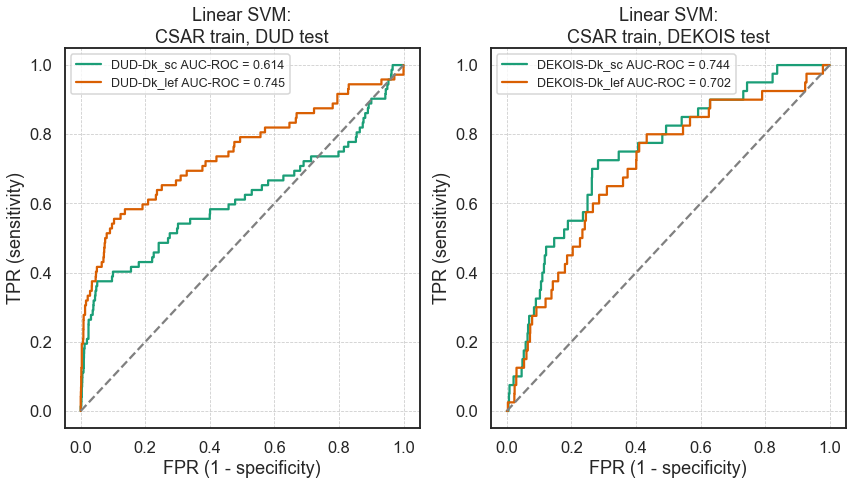

In [27]:
RF_features = SelectFromModel(model_rf, prefit= True, max_features = 10)
conformaciones = X_dkef_CSAR.columns[RF_features.get_support()]
print(conformaciones)

svc_params = {'C': [1]}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'

test_keys = ['DUD', 'DEKOIS']

svm = SVC
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= SVC, estimator_params = svc_params,
                        selected_features = conformaciones,
                        kernel = 'linear', probability = True)

# TESTING PHASE: Evaluation of the model with the given sets (test_keys)
svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            selected_features = conformaciones,
                            scores_dic = scores_dic, decreasing = False)
# Visualization

plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)


#### Decision Tree Features

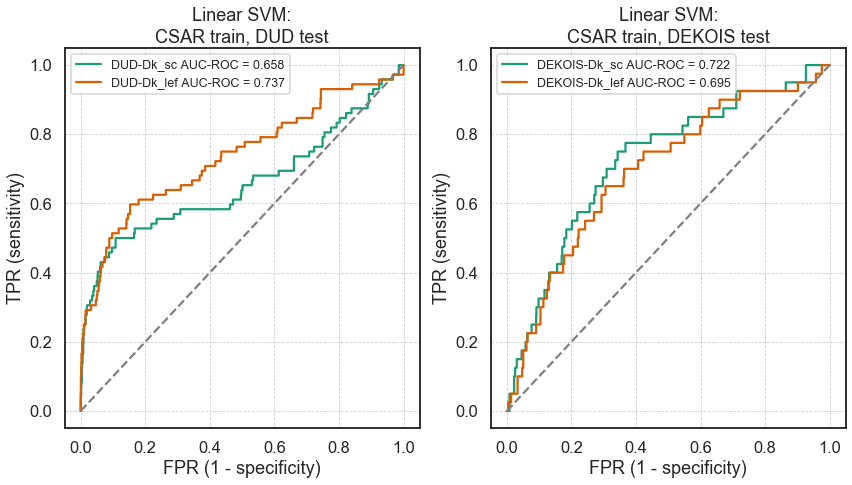

In [28]:
tree_features = features_tree
conformaciones = tree_features
print(conformaciones)

svc_params = {'C': [1]}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'

test_keys = ['DUD', 'DEKOIS']

svm = SVC
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= SVC, estimator_params = svc_params,
                        selected_features = conformaciones,
                        kernel = 'linear', probability = True)

# TESTING PHASE: Evaluation of the model with the given sets (test_keys)
svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            selected_features = conformaciones,
                            scores_dic = scores_dic, decreasing = False)
# Visualization

plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)


### RBF SVC with selected features
<div style='background-color: #F9E5AB; min-height: 5px'></div>

#### Random Forest Features

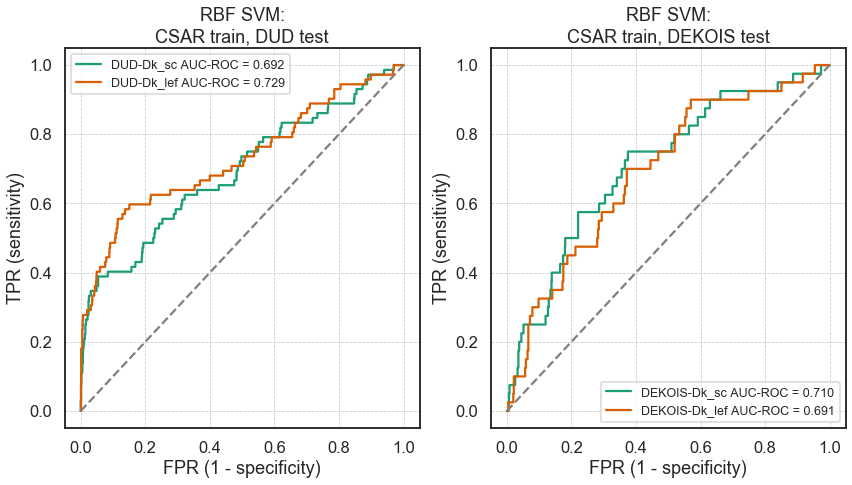

In [29]:
RF_features = SelectFromModel(model_rf, prefit= True, max_features = 10)
conformaciones = X_dkef_CSAR.columns[RF_features.get_support()]
print(conformaciones)

svc_params = {'gamma': [0.01, 0.1, 1, 10], 'C': np.geomspace(0.1, 100, 4)}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
# Training phase
svm = SVC
svm_rbf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= SVC, estimator_params = svc_params,
                        selected_features = conformaciones,
                        kernel = 'rbf', probability = True)
# Evaluation
svm_rbf_pred = eval_wrapper(trained_model = svm_rbf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            selected_features = conformaciones,
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'RBF SVM', predictions = svm_rbf_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)

#### Decision Tree Features

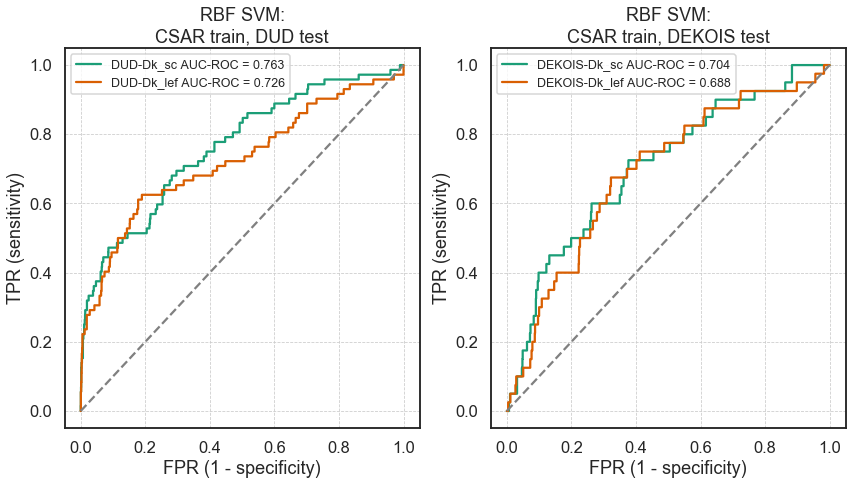

In [30]:
tree_features = features_tree
conformaciones = tree_features
print(conformaciones)

svc_params = {'gamma': [0.01, 0.1, 1, 10], 'C': np.geomspace(0.1, 100, 4)}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
# Training phase
svm = SVC
svm_rbf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= SVC, estimator_params = svc_params,
                        selected_features = conformaciones,
                        kernel = 'rbf', probability = True)
# Evaluation
svm_rbf_pred = eval_wrapper(trained_model = svm_rbf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            selected_features = conformaciones,
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'RBF SVM', predictions = svm_rbf_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)